# Fish monitoring pipeline 

Some setup...

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from util.data_utils import *

%load_ext autoreload
%autoreload 2

new_style = {'grid': False}
plt.rc('axes', **new_style)
p = sns.color_palette()

Using TensorFlow backend.


### Load data

Load localizer train dataset. This dataset comprises of images taken from different boat decks with fishes of different species. They are annotated with the position (x, y, w, h) where each fish is located in each image.

In [2]:
boxes = pd.read_csv('/a/data/fisheries_monitoring/data/detection_labels/boxes.csv',
                     names = ["img", "x","y","w","h"])
 
INPUT_LOC_WIDTH = 224
INPUT_LOC_HEIGHT = 224
PATH = '/a/data/fisheries_monitoring/data/localizers/original/'
loc_data, loc_target, loc_index = load_raw_data(boxes, INPUT_LOC_WIDTH, INPUT_LOC_HEIGHT, PATH)
#loc_res_data, loc_res_target, loc_res_index = resize_data_and_boxes(loc_data, loc_target, loc_index,
                                                                    
print "Localizer train dataset shape:", loc_data.shape
print "Localizer annotated boxes shape:", loc_target.shape

Localizer train dataset shape: (4371, 224, 224, 3)
Localizer annotated boxes shape: (4371, 4)


Load classifier labels and train dataset. This dataset is build by cropped images from the original dataset in which the fish ocuppies most part of the image. The labels are the specie of each fish.

In [3]:
INPUT_CLS_WIDTH = 224
INPUT_CLS_HEIGHT = 224
PATH = '/a/data/fisheries_monitoring/data/classifiers/cropped_from_origin'

train_data, train_target, train_id = load_cropped_train(PATH, INPUT_CLS_WIDTH, INPUT_CLS_HEIGHT)

print 'Convert to numpy...'
train_data = np.array(train_data)
train_target = np.array(train_target)

print 'Convert to float...'
train_data = train_data.astype('float32')
cropped_data = train_data / 255
labels = np_utils.to_categorical(train_target, 8)

print 'Train shape:', cropped_data.shape
print cropped_data.shape[0], 'train samples'

Read train images
Load folder ALB (Index: 0)
Load folder BET (Index: 1)
Load folder DOL (Index: 2)
Load folder LAG (Index: 3)
Load folder OTHER (Index: 4)
Load folder SHARK (Index: 5)
Load folder YFT (Index: 6)
Load folder NoF (Index: 7)
Read train data time: 50.86 seconds
Convert to numpy...
Convert to float...
Train shape: (4836, 224, 224, 3)
4836 train samples


### Create pipeline with desired localizer and classifier

In [50]:
from models.pipeline import Pipeline
import models.classifiers as cls
import models.localizers as loc

cls_name = "first_model"
#model = Pipeline(loc.ResNet50(), cls.ResNet50(), cls_weights=cls_name)
model = Pipeline(cls=cls.ResNet50(),cls_weights=cls_name,
                 loc_weights=cls_name,
                 only_weights=False)

### Train model

Split localizer dataset and set it into the pipeline

In [6]:
#X_loc_train, X_loc_test, y_loc_train, y_loc_test = train_test_split(loc_data, loc_target,
#                                                                    test_size=0.2, random_state=0#)
loc_train, loc_val, loc_test = train_val_test_split(loc_data, loc_target, np.array(loc_index), 0.7,0.2)

In [19]:
model.set_localizer_train_data(X_loc_train, y_loc_train, X_loc_test, y_loc_test)

In [9]:
X_loc_train.shape

(3496, 224, 224, 3)

Do the same for the classifier dataset

In [10]:
#X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(cropped_data, labels,
#                                                                    test_size=0.2, random_state=0)
cls_train, cls_val, cls_test = train_val_test_split(cropped_data, labels, np.array(train_id), 0.7, 0.2)

In [17]:
model.set_classifier_train_data(X_cls_train, y_cls_train, X_cls_test, y_cls_test)

Now, train

In [ ]:
loc_batch_size = 16
loc_num_epoch = 50

cls_batch_size = 16
cls_num_epoch = 30

model.fit(loc_batch_size, loc_num_epoch, cls_batch_size, cls_num_epoch)

### Testing the model

In [51]:
# TODO: We are using for testing the same dataset as for validation, need to change it
predictions = model.predict(loc_test['X'].astype('float32'), batch_size=16)
# Compute loss
score = log_loss(loc_test['y'], predictions)
print "log loss score: ", score

438/438 [==============================] - 7s     


ValueError: Unknown label type: (array([[[[ 251.,  251.,  250.],
         [ 249.,  249.,  248.],
         [ 250.,  250.,  249.],
         ..., 
         [ 184.,  194.,  228.],
         [ 168.,  181.,  221.],
         [ 171.,  185.,  225.]],

        [[ 216.,  214.,  211.],
         [ 189.,  187.,  188.],
         [ 196.,  195.,  197.],
         ..., 
         [ 246.,  249.,  252.],
         [ 235.,  239.,  247.],
         [ 226.,  232.,  242.]],

        [[ 201.,  199.,  194.],
         [ 174.,  172.,  173.],
         [ 191.,  191.,  196.],
         ..., 
         [ 254.,  252.,  254.],
         [ 254.,  252.,  254.],
         [ 254.,  254.,  253.]],

        ..., 
        [[ 120.,  107.,  104.],
         [ 117.,  106.,  102.],
         [ 115.,  105.,  101.],
         ..., 
         [  85.,   86.,   77.],
         [  95.,   97.,   86.],
         [ 106.,  108.,   96.]],

        [[ 120.,  107.,  104.],
         [ 118.,  107.,  103.],
         [ 116.,  106.,  102.],
         ..., 
         [  85.,   86.,   78.],
         [  95.,   96.,   87.],
         [ 105.,  107.,   96.]],

        [[ 120.,  107.,  104.],
         [ 118.,  107.,  103.],
         [ 116.,  106.,  102.],
         ..., 
         [  85.,   86.,   78.],
         [  95.,   96.,   88.],
         [ 103.,  105.,   94.]]],


       [[[  68.,   81.,   89.],
         [  68.,   81.,   89.],
         [  68.,   81.,   89.],
         ..., 
         [  85.,   91.,   89.],
         [  85.,   91.,   89.],
         [  84.,   90.,   88.]],

        [[  66.,   79.,   87.],
         [  66.,   79.,   87.],
         [  66.,   79.,   87.],
         ..., 
         [  85.,   91.,   89.],
         [  85.,   91.,   89.],
         [  84.,   90.,   88.]],

        [[  64.,   77.,   85.],
         [  64.,   77.,   85.],
         [  64.,   77.,   85.],
         ..., 
         [  85.,   91.,   89.],
         [  85.,   91.,   89.],
         [  84.,   90.,   88.]],

        ..., 
        [[  76.,   72.,   60.],
         [  76.,   72.,   60.],
         [  76.,   72.,   60.],
         ..., 
         [  83.,   92.,   91.],
         [  83.,   92.,   91.],
         [  82.,   91.,   90.]],

        [[  73.,   69.,   57.],
         [  74.,   70.,   58.],
         [  74.,   70.,   58.],
         ..., 
         [  83.,   92.,   91.],
         [  83.,   92.,   91.],
         [  82.,   91.,   90.]],

        [[  72.,   68.,   56.],
         [  73.,   69.,   57.],
         [  73.,   69.,   57.],
         ..., 
         [  83.,   92.,   91.],
         [  83.,   92.,   91.],
         [  82.,   91.,   90.]]],


       [[[ 175.,  188.,  178.],
         [ 178.,  190.,  186.],
         [ 192.,  203.,  205.],
         ..., 
         [ 184.,  180.,  174.],
         [ 187.,  182.,  178.],
         [ 185.,  180.,  179.]],

        [[ 176.,  189.,  180.],
         [ 177.,  190.,  186.],
         [ 183.,  194.,  196.],
         ..., 
         [ 182.,  178.,  173.],
         [ 183.,  178.,  175.],
         [ 186.,  180.,  180.]],

        [[ 179.,  192.,  183.],
         [ 176.,  188.,  185.],
         [ 178.,  189.,  190.],
         ..., 
         [ 183.,  178.,  173.],
         [ 180.,  175.,  172.],
         [ 183.,  177.,  177.]],

        ..., 
        [[  92.,  107.,  114.],
         [  40.,   55.,   62.],
         [  37.,   52.,   60.],
         ..., 
         [ 108.,   90.,   83.],
         [ 108.,   89.,   83.],
         [ 108.,   89.,   83.]],

        [[  79.,   94.,  101.],
         [  39.,   54.,   61.],
         [  40.,   55.,   62.],
         ..., 
         [ 106.,   89.,   82.],
         [ 105.,   89.,   82.],
         [ 105.,   88.,   81.]],

        [[  32.,   47.,   54.],
         [  37.,   52.,   59.],
         [  42.,   57.,   64.],
         ..., 
         [ 105.,   89.,   82.],
         [ 102.,   87.,   80.],
         [ 100.,   85.,   78.]]],


       ..., 
       [[[ 173.,  178.,  172.],
         [ 178.,  183.,  177.],
         [ 178.,  183.,  178.],
         ..., 
         [  77.,   87.,  100.],
         [  76.,   86.,   98.],
         [  75.,   85.,   97.]],

        [[ 173.,  178.,  172.],
         [ 177.,  182.,  176.],
         [ 177.,  182.,  177.],
         ..., 
         [  77.,   87.,  100.],
         [  76.,   86.,   98.],
         [  75.,   85.,   97.]],

        [[ 174.,  179.,  173.],
         [ 177.,  182.,  176.],
         [ 178.,  183.,  178.],
         ..., 
         [  79.,   89.,  101.],
         [  78.,   88.,  100.],
         [  77.,   87.,   99.]],

        ..., 
        [[ 140.,  149.,  146.],
         [ 141.,  150.,  147.],
         [ 144.,  151.,  148.],
         ..., 
         [  94.,  102.,  113.],
         [ 128.,  134.,  144.],
         [ 156.,  158.,  168.]],

        [[ 139.,  148.,  145.],
         [ 141.,  150.,  147.],
         [ 144.,  151.,  148.],
         ..., 
         [  92.,  100.,  110.],
         [ 152.,  158.,  164.],
         [ 186.,  190.,  194.]],

        [[ 139.,  148.,  145.],
         [ 141.,  150.,  147.],
         [ 144.,  151.,  148.],
         ..., 
         [  91.,   99.,  108.],
         [ 155.,  161.,  165.],
         [ 192.,  197.,  195.]]],


       [[[  12.,   15.,   24.],
         [  13.,   16.,   25.],
         [  13.,   16.,   25.],
         ..., 
         [ 220.,  229.,  233.],
         [ 209.,  220.,  226.],
         [ 211.,  222.,  228.]],

        [[  12.,   15.,   24.],
         [  13.,   16.,   25.],
         [  13.,   16.,   25.],
         ..., 
         [ 218.,  227.,  232.],
         [ 211.,  222.,  228.],
         [ 213.,  224.,  230.]],

        [[  12.,   15.,   24.],
         [  13.,   16.,   25.],
         [  13.,   16.,   25.],
         ..., 
         [ 219.,  228.,  233.],
         [ 213.,  224.,  230.],
         [ 215.,  226.,  232.]],

        ..., 
        [[  14.,   14.,   25.],
         [  14.,   14.,   23.],
         [  14.,   15.,   20.],
         ..., 
         [ 130.,  111.,  103.],
         [ 123.,  105.,  100.],
         [ 122.,  106.,   95.]],

        [[  14.,   14.,   25.],
         [  14.,   14.,   23.],
         [  14.,   15.,   20.],
         ..., 
         [ 129.,  110.,  102.],
         [ 122.,  104.,   99.],
         [ 120.,  103.,   92.]],

        [[  14.,   14.,   25.],
         [  14.,   14.,   23.],
         [  14.,   15.,   20.],
         ..., 
         [ 129.,  110.,  102.],
         [ 120.,  103.,   97.],
         [ 109.,   93.,   82.]]],


       [[[  95.,  114.,  108.],
         [ 105.,  119.,  114.],
         [ 109.,  129.,  121.],
         ..., 
         [  11.,   18.,   26.],
         [  11.,   18.,   26.],
         [  11.,   18.,   26.]],

        [[ 112.,  131.,  125.],
         [ 122.,  141.,  135.],
         [ 127.,  152.,  141.],
         ..., 
         [  11.,   18.,   26.],
         [  11.,   18.,   26.],
         [  11.,   18.,   26.]],

        [[ 126.,  145.,  139.],
         [ 121.,  139.,  133.],
         [ 127.,  135.,  127.],
         ..., 
         [  11.,   18.,   26.],
         [  11.,   18.,   26.],
         [  11.,   18.,   26.]],

        ..., 
        [[ 156.,  154.,  140.],
         [ 117.,  117.,  107.],
         [ 122.,  123.,  116.],
         ..., 
         [  12.,   17.,   21.],
         [  12.,   17.,   21.],
         [  12.,   17.,   21.]],

        [[ 148.,  146.,  131.],
         [  89.,   89.,   79.],
         [ 123.,  124.,  117.],
         ..., 
         [  12.,   17.,   21.],
         [  12.,   17.,   21.],
         [  12.,   17.,   21.]],

        [[ 181.,  179.,  164.],
         [  88.,   88.,   78.],
         [ 146.,  147.,  140.],
         ..., 
         [  12.,   17.,   21.],
         [  11.,   16.,   20.],
         [  11.,   16.,   20.]]]]),)

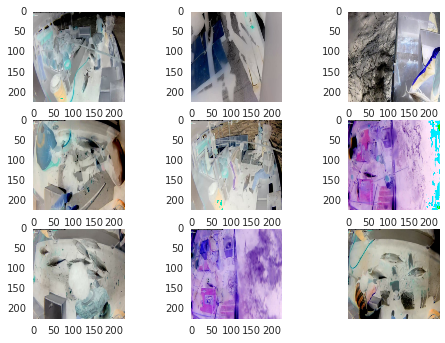

In [52]:
model.visualize_predictions()

Compute accuracy

In [13]:
acc = (np.argmax(predictions, 1) == np.argmax(cls_test['y'], 1)).mean()

print "accuracy: ", acc

accuracy:  0.520661157025


In [72]:
model.save_models(cls_name="first_model")

In [47]:
print predictions.shape
print model.box_predictions['pred'][2]

(438, 4)
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.78782976e-25]
